# I. INITIAL IMPORTS (more found throughout workbook)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
import explore

from acquire import get_zillow_data
from wrangle import wrangle_zillow
from wrangle import scale_zillow
from splitter import splitter

import warnings
warnings.filterwarnings("ignore")

# II. LOAD DATA

## Step 1 - Dataset analyzed in SQL
- Decided on features to use from properties_2017 table based on initial analysis that the following numerical features are important: Year built, number of bathrooms and bedrooms, building quality type (on a scale from 1-12, but continuous), calculated finsihed square feet, lot size in square feet, and the number of fireplaces, pools and garages.  Selected one categorical feature, fips.  
- Right joined with predictions_2017 on 'parcelid'
- See acquire.py for SQL query used (to include features selected)

In [2]:
df = get_zillow_data()
df.sample(5)

,bedrooms,bathrooms,sqft,selling_price,yearbuilt,quality,fireplaces,lotsize,pools,garages,fips
45336,4.0,2.0,2650.0,137475.0,1936.0,8.0,NaN,7770.0,1.0,NaN,6037.0
18530,3.0,2.0,1429.0,295814.0,1985.0,8.0,NaN,41714.0,NaN,NaN,6037.0
15463,3.0,3.0,2320.0,538322.0,1959.0,NaN,NaN,8658.0,NaN,2.0,6059.0
37876,5.0,3.5,2774.0,492810.0,2004.0,NaN,1.0,8800.0,1.0,2.0,6059.0
22983,3.0,1.0,1008.0,206522.0,1944.0,4.0,NaN,6751.0,NaN,NaN,6037.0


##### Creating a 'save point' for the raw df.

In [3]:
df_raw_SP = df.copy()

## Step 2 - Examine data to determine how to prep/clean (for wrangle.py file)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       52442 non-null  float64
 1   bathrooms      52442 non-null  float64
 2   sqft           52360 non-null  float64
 3   selling_price  52441 non-null  float64
 4   yearbuilt      52326 non-null  float64
 5   quality        33741 non-null  float64
 6   fireplaces     7243 non-null   float64
 7   lotsize        52073 non-null  float64
 8   pools          11096 non-null  float64
 9   garages        18015 non-null  float64
 10  fips           52442 non-null  float64
dtypes: float64(11)
memory usage: 4.8 MB


##### Check for dupliactes:

In [5]:
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       52442 non-null  float64
 1   bathrooms      52442 non-null  float64
 2   sqft           52360 non-null  float64
 3   selling_price  52441 non-null  float64
 4   yearbuilt      52326 non-null  float64
 5   quality        33741 non-null  float64
 6   fireplaces     7243 non-null   float64
 7   lotsize        52073 non-null  float64
 8   pools          11096 non-null  float64
 9   garages        18015 non-null  float64
 10  fips           52442 non-null  float64
dtypes: float64(11)
memory usage: 4.8 MB


##### Run value counts on all columns:

In [6]:
for i in df.columns:
    print(i)
    print(df[i].value_counts())
    print(f'{df[df[i].isnull()].shape[0]} null values')
    print('\n-----\n')

bedrooms
3.0     23360
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedrooms, dtype: int64
0 null values

-----

bathrooms
2.0     21894
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathrooms, dtype: int64
0 null values

-----

sqft
1120.0    128
1200.0    119
1080.0    102
1040.0     86
936.0      86
         ... 
7088.0      1
604.0       1
5422.0      1
534.0       1
5655.0      1
Name: sqft, Length: 4723, dtype: int64
82 null values

-----

selling_price
455000.0    34
600000.0    30
550000.0    24
500000.0    24
450000.0    24
            ..
209341.0     1
203304.0     1
497409.0     1
4219

##### After examination of the value counts, my initial cleaning consists of the following:
1. It seems that fireplaces, pools and garages are all NaN if they have none.  Therefore, I will replace all their NaNs with a zero.
2. I need to investigate the quality score more, as it may be a strong predictor of value, but has a very large number of Nulls.  Quality is a metric from 1 (best) to 12 (worst).  Is there a way to fill in those numbers based on other features?

In [7]:
df['fireplaces'] = df.fireplaces.fillna(value=0)
df['pools'] = df.pools.fillna(value=0)
df['garages'] = df.garages.fillna(value=0)
df.head(2)

,bedrooms,bathrooms,sqft,selling_price,yearbuilt,quality,fireplaces,lotsize,pools,garages,fips
0,4.0,3.5,3100.0,1023282.0,1998.0,NaN,0.0,4506.0,0.0,2.0,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,NaN,1.0,12647.0,0.0,1.0,6111.0


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,52442.0,3.300675,0.949086,0.0,3.0,3.0,4.0,14.0
bathrooms,52442.0,2.299397,1.022764,0.0,2.0,2.0,3.0,18.0
sqft,52360.0,1922.874083,1004.363491,128.0,1268.0,1659.0,2306.0,21929.0
selling_price,52441.0,529683.008524,751888.311091,1000.0,193750.0,373612.0,619301.0,49061236.0
yearbuilt,52326.0,1963.393820,23.133355,1878.0,1950.0,1961.0,1979.0,2016.0
quality,33741.0,6.264100,1.716181,1.0,5.0,6.0,8.0,12.0
fireplaces,52442.0,0.167099,0.458883,0.0,0.0,0.0,0.0,5.0
lotsize,52073.0,11339.520135,86746.804342,236.0,5583.0,6840.0,8798.0,6971010.0
pools,52442.0,0.211586,0.408437,0.0,0.0,0.0,0.0,1.0
garages,52442.0,0.669521,0.980069,0.0,0.0,0.0,2.0,14.0


### *Quality Investigation:*

#### In a seperate workbook ('*zillow_quality_feature_investigation.ipynb*') I analyzed the 'buildingqualitytypeid' metric from the database as a 'quality' score.  After examining its impact, I decided not to include it.

### I used the following general line of code to examine each feature in details to determine where to cut values off: df[df[feature]>n].sort_values(by=feature)

##### From this I determined the following to remove some of the larger outliers, to be done in wrangle:
1. Set range of bedrooms and bathrooms from 1-6 (0<b<7)
2. Remove all listings with a home size greater than 10,000 sqft and less than 400 sqft
3. Remove all listings with more than 4 garages (g<5)
4. Remove all listing with more than 3 fireplaces (f<4)
5. Remove listings with a selling_price greater than \$10MM or less than 10k
6. Remove all listings with a lot size greater than 217,800 sqft (5 acres)
7. Also remove all listings with a lot size less than 1/2 the sqft of the home.

In [9]:
df = df.drop(columns='quality')
df = df.dropna()

##### Creating a Save Point before outlier removal

In [10]:
df_dirty_SP = df.copy()

In [11]:
df = df[df['bathrooms'] > 0]
df = df[df['bedrooms'] > 0]
df = df[df['bathrooms'] < 7]
df = df[df['bedrooms'] < 7]
df = df[df['sqft'] > 400]
df = df[df['sqft'] < 10000]
df = df[df['selling_price'] > 10000]
df = df[df['selling_price'] < 5000000]
df = df[df['fireplaces'] < 4]
df = df[df['garages'] < 5]
df = df[df['lotsize'] < 217800]
df = df[df['lotsize'] > (.5 * df['sqft'])]
df.shape[0]/df_dirty_SP.shape[0]

0.9862971516551193

This leaves ~98.6% of the records for exploration and modeling.

In addition to removing these listings, I will also convert floats to integers, where applicable, and rename the fips with their actual names.

In [12]:
df = df.astype({'bedrooms':'int', 'bathrooms':'int','sqft':'int', 'selling_price':'int', 'yearbuilt':'int','fireplaces':'int','lotsize':'int','pools':'int','garages':'int'})

In [13]:
df['fips_name'] = np.where(df.fips == 6037, 'Los Angeles', np.where(df.fips == 6059, 'Orange','Ventura') )
df = df.drop(columns = 'fips')

# III. UNIVARIATE PLOTS AND INITIAL HYPOTHESIS

bedrooms


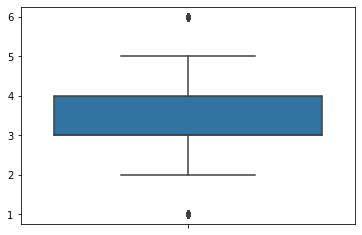


-----

bathrooms


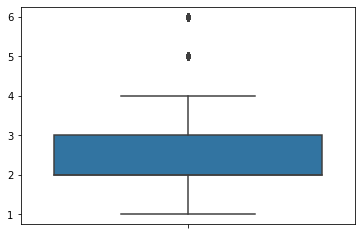


-----

sqft


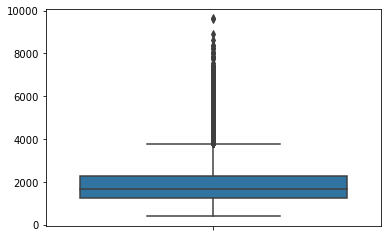


-----

selling_price


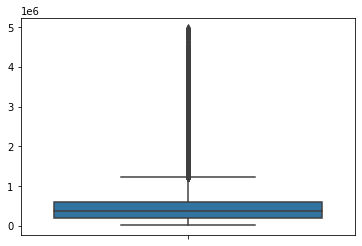


-----

yearbuilt


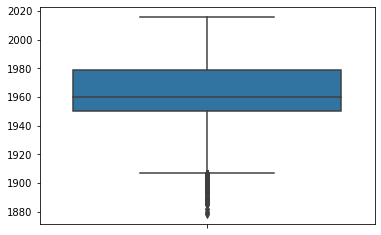


-----

fireplaces


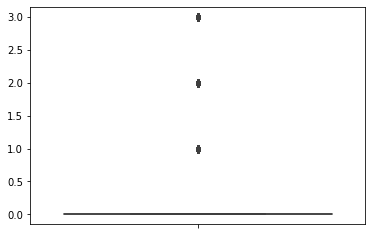


-----

lotsize


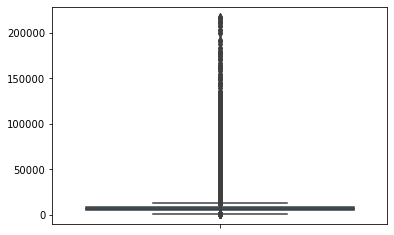


-----

pools


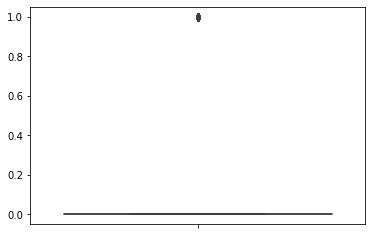


-----

garages


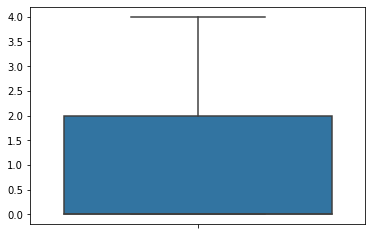


-----



In [14]:
for col in df.drop(columns='fips_name').columns:
    print(col)
    sns.boxplot(y=df[col].values)
    plt.show()
    print('\n-----\n')

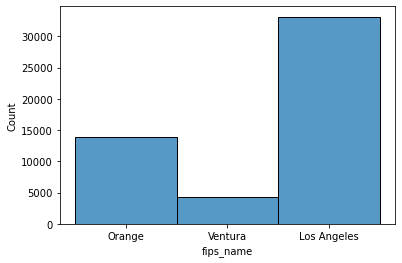

In [15]:
sns.histplot(x='fips_name',data=df)
plt.show()

## Initial Hypotheses
1. Having a fireplace(s), garage(s) and/or pool increases home value.
2. Larger lot size increases home value.
3. Larger square foot size increases home value.
4. More bedrooms and bathrooms increase home value.
5. There is a difference in home values due to geography.

# IV. BIVARIATE AND MULTIVARIATE EDA

#### First, we must split the data.  I want to ensure an important categorical variable, fips name, is equally distributed across the splits, so I will stratify on fips_name.

In [16]:
train, validate, test = splitter(df, target='fips_name')
train.head(2)

Train = 28698 rows (56.0%) | Validate = 12300 rows (24.0%) | Test = 10250 rows (20.0%)


,bedrooms,bathrooms,sqft,selling_price,yearbuilt,fireplaces,lotsize,pools,garages,fips_name
24401,3,2,1163,505000,2000,1,3757,0,1,Ventura
11376,4,3,2633,420576,1994,0,8000,0,2,Orange


Plot all variable pairs to look for correlations.

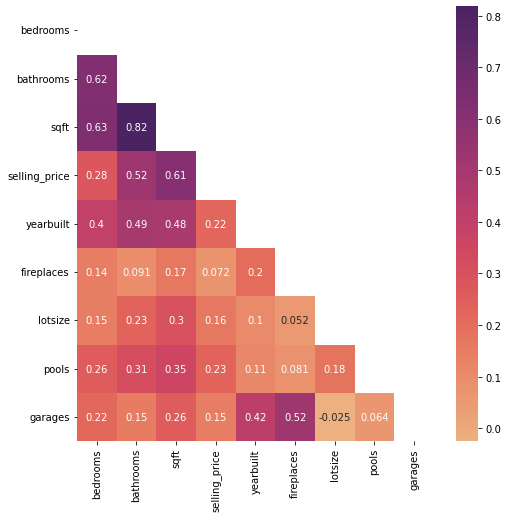

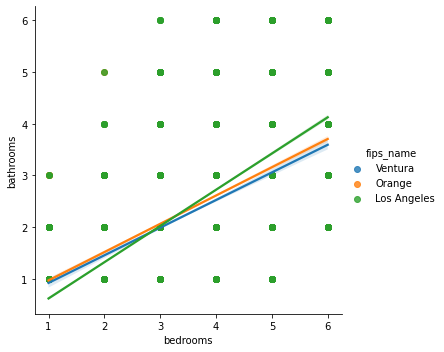

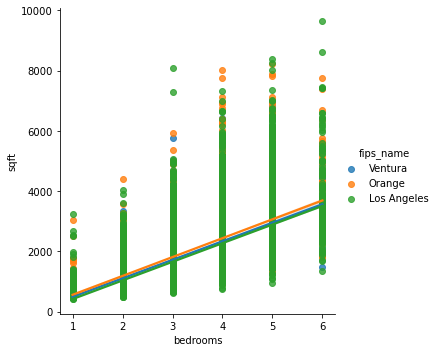

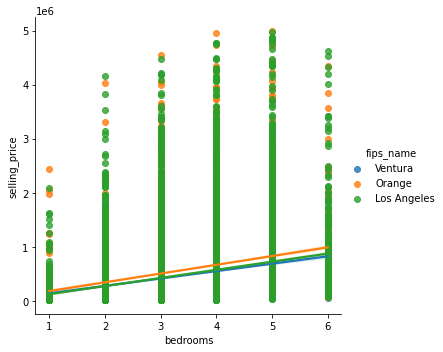

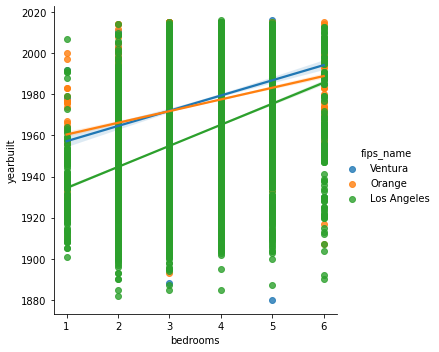

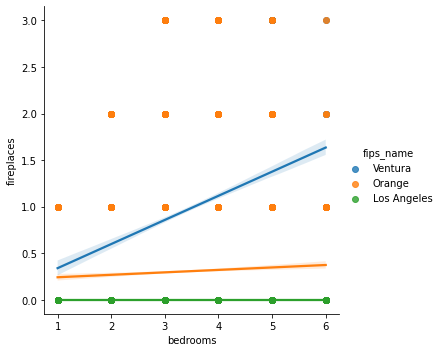

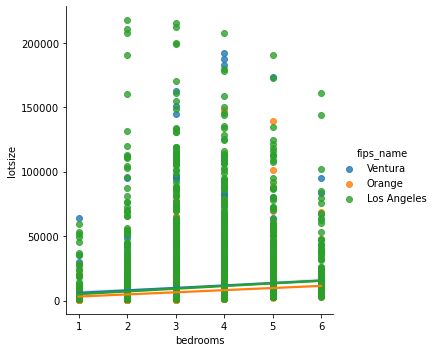

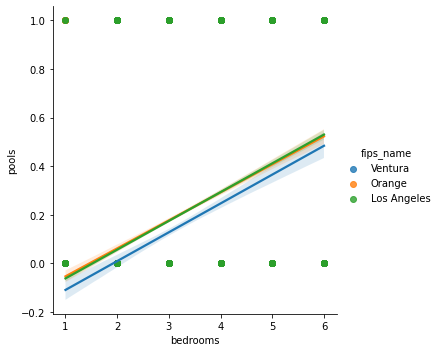

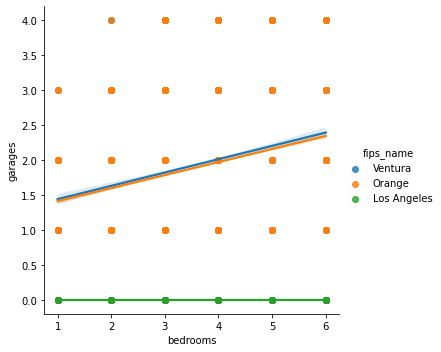

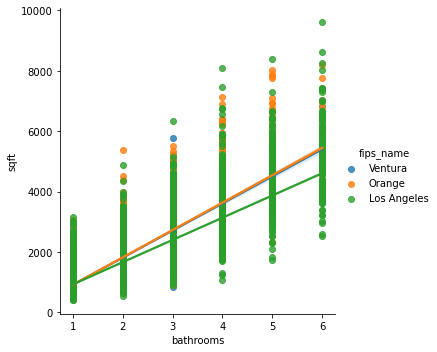

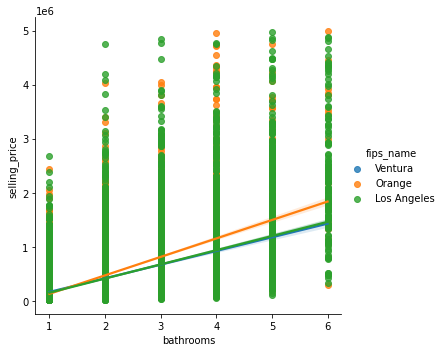

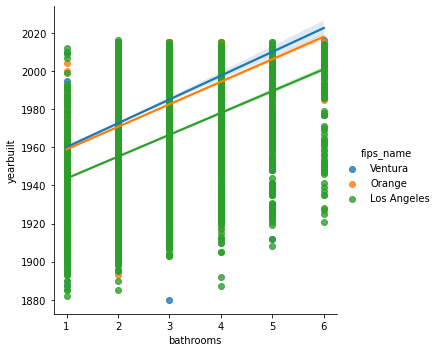

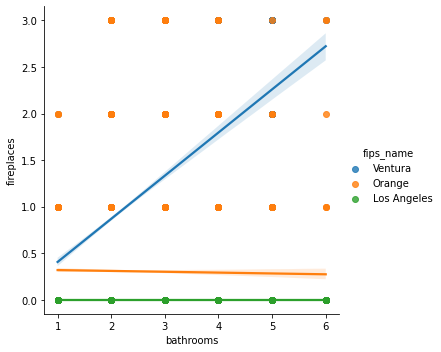

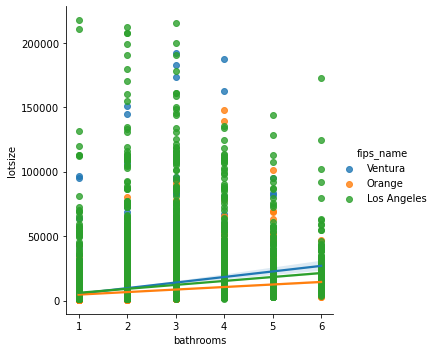

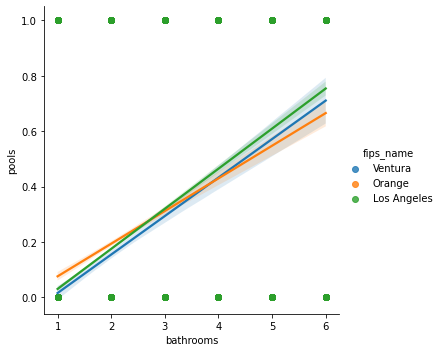

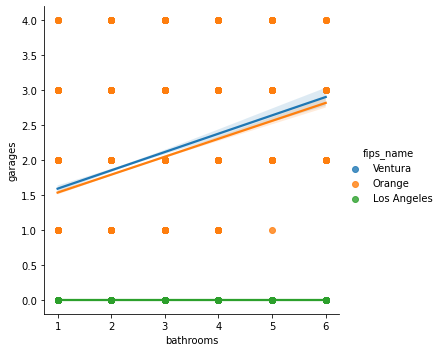

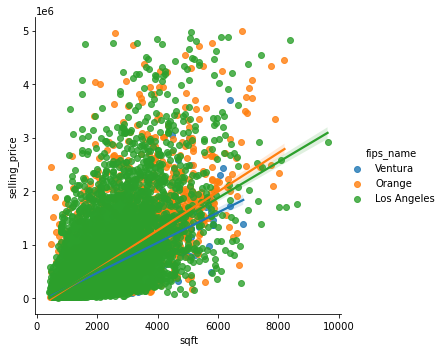

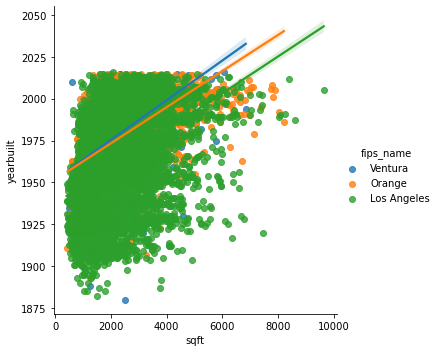

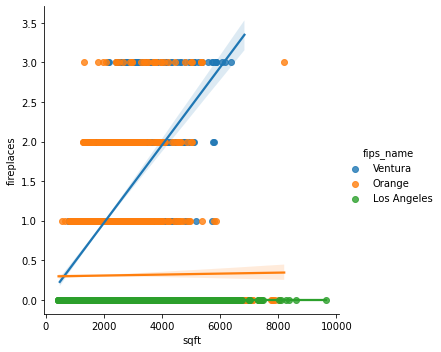

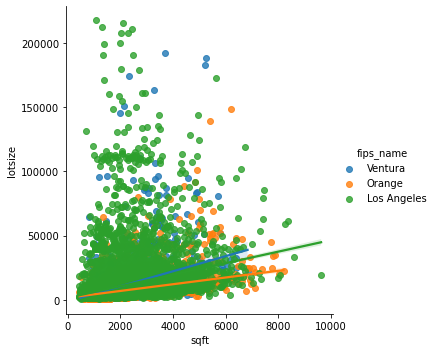

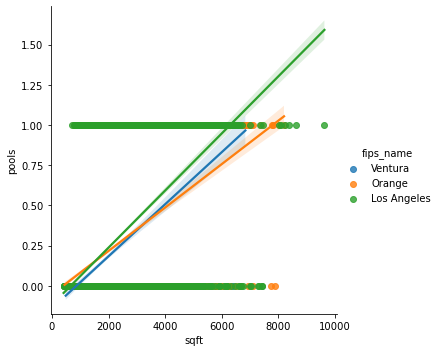

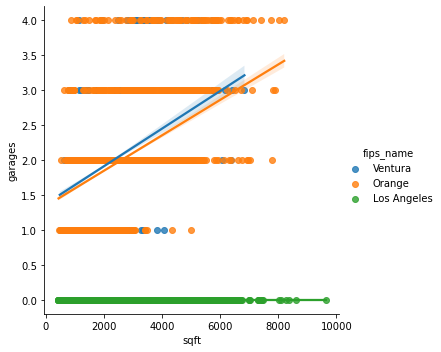

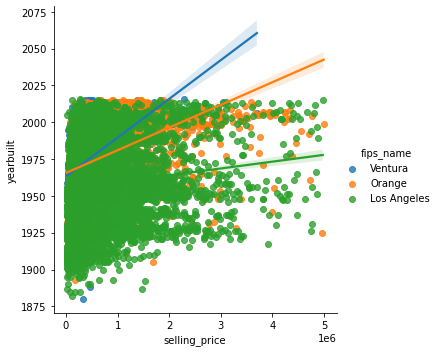

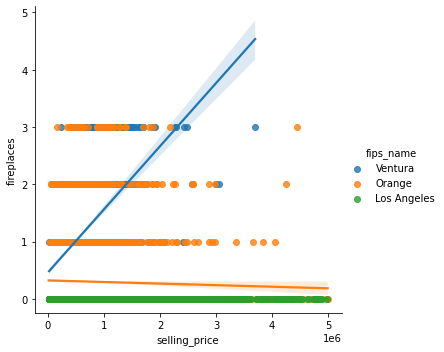

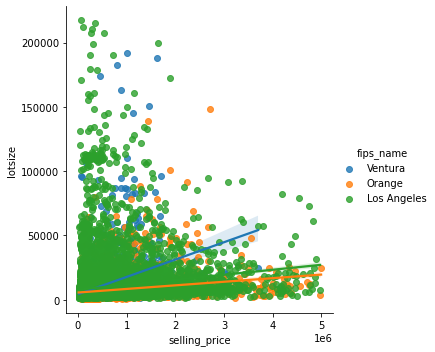

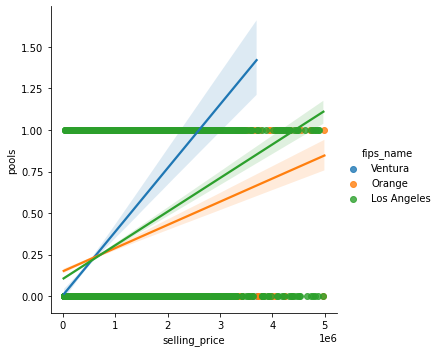

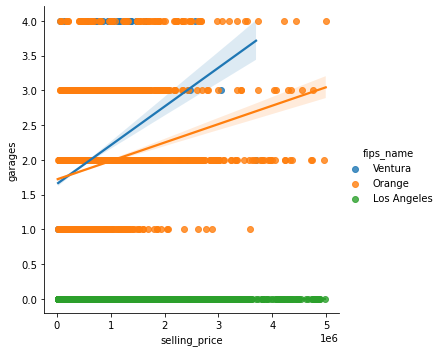

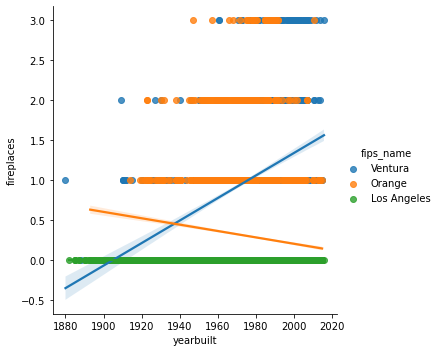

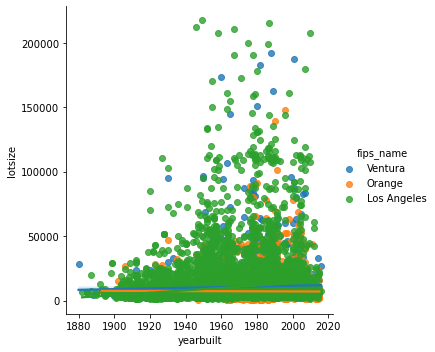

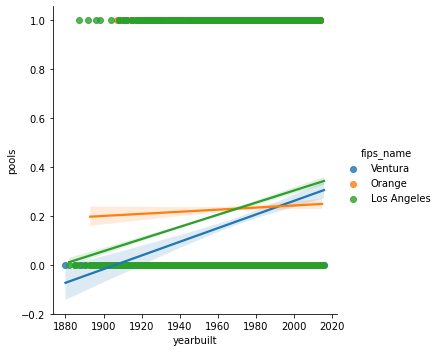

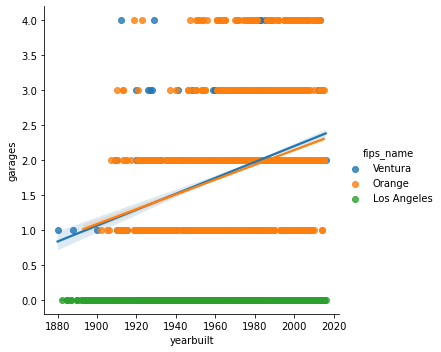

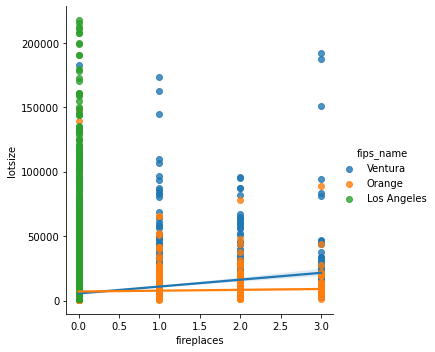

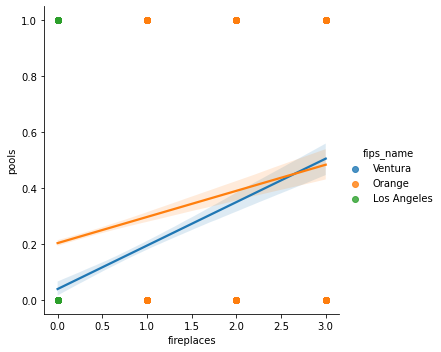

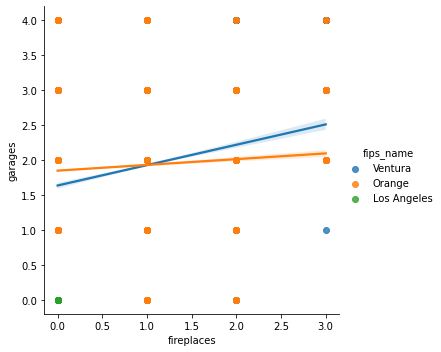

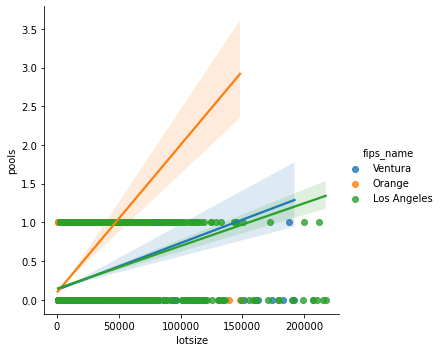

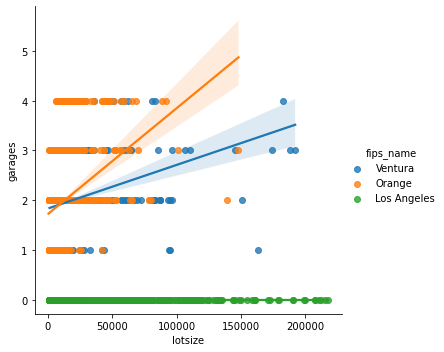

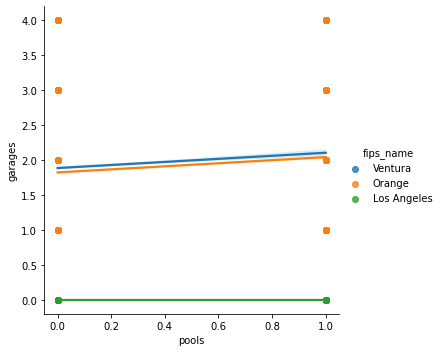

In [17]:
explore.plot_variable_pairs(train)

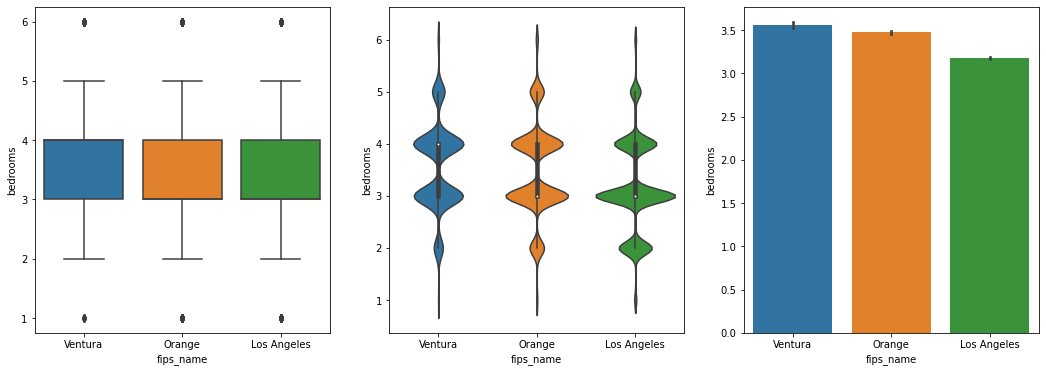

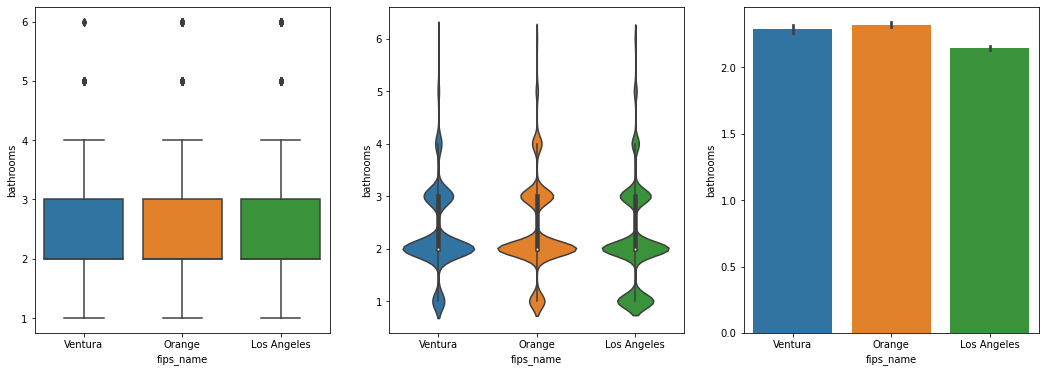

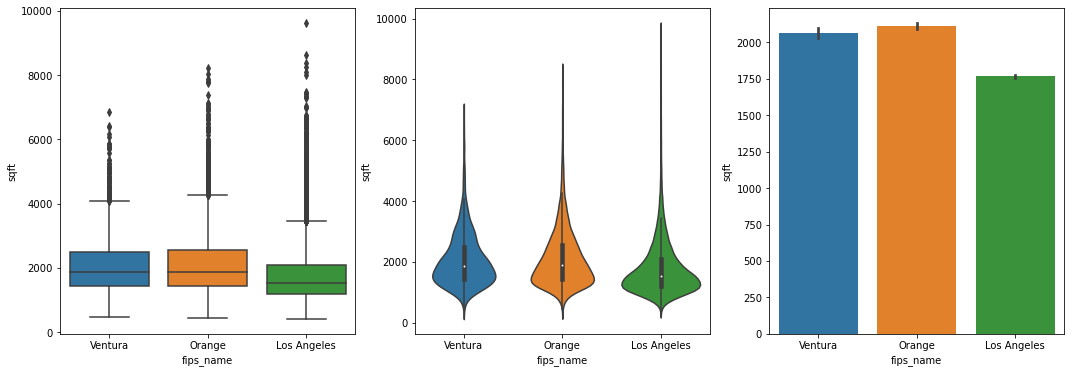

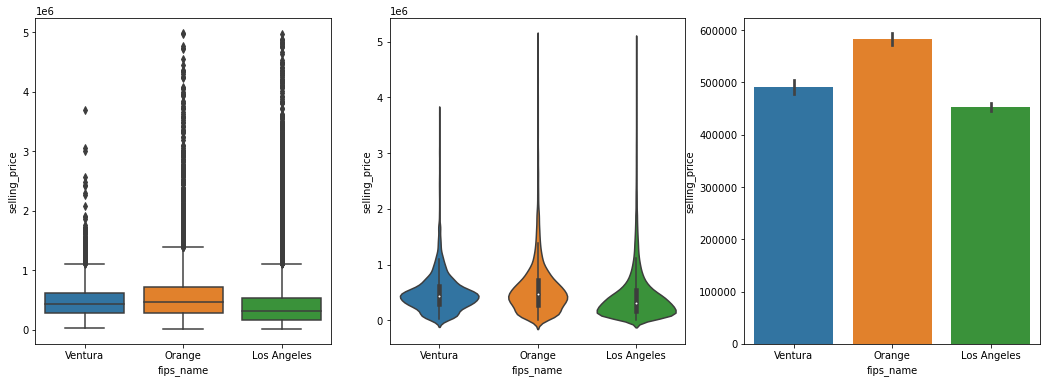

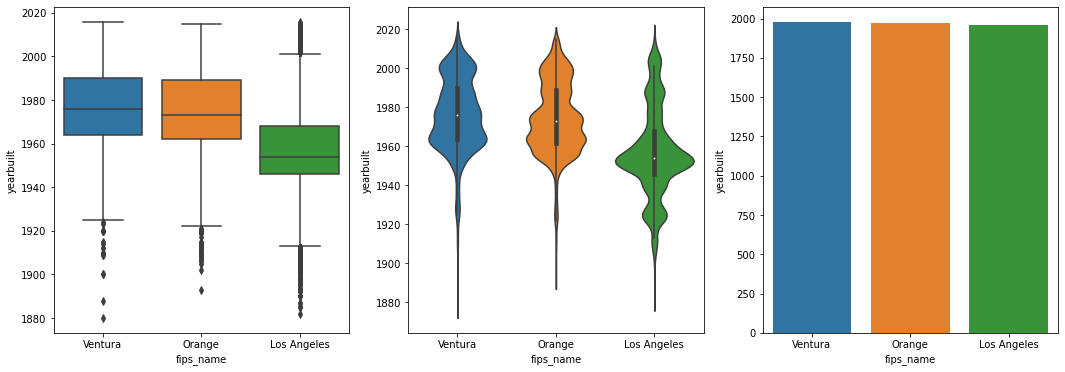

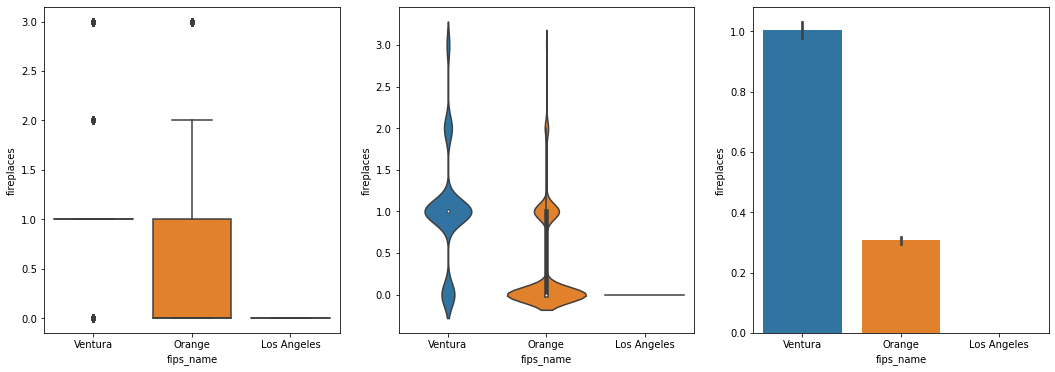

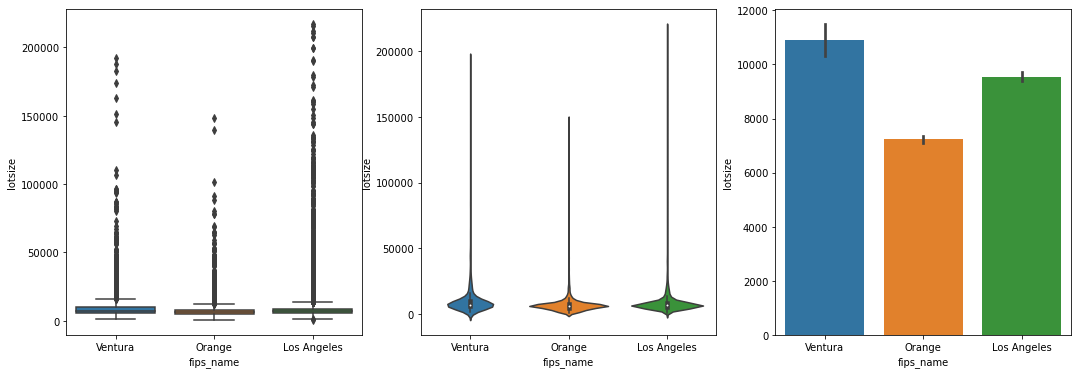

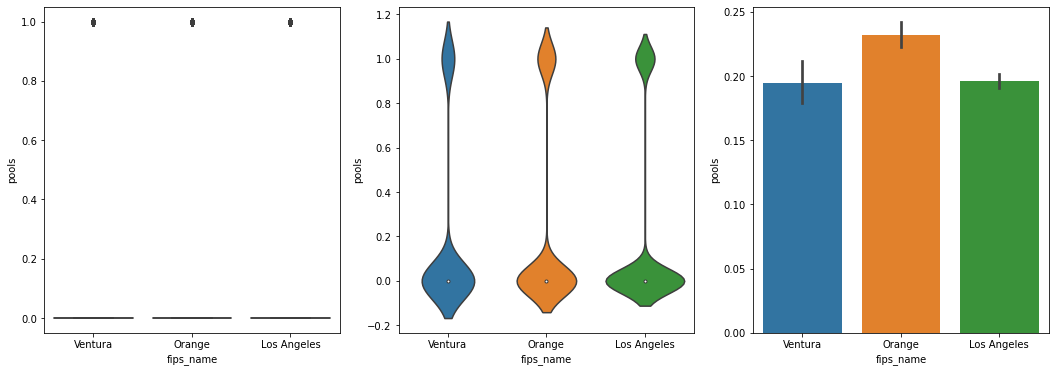

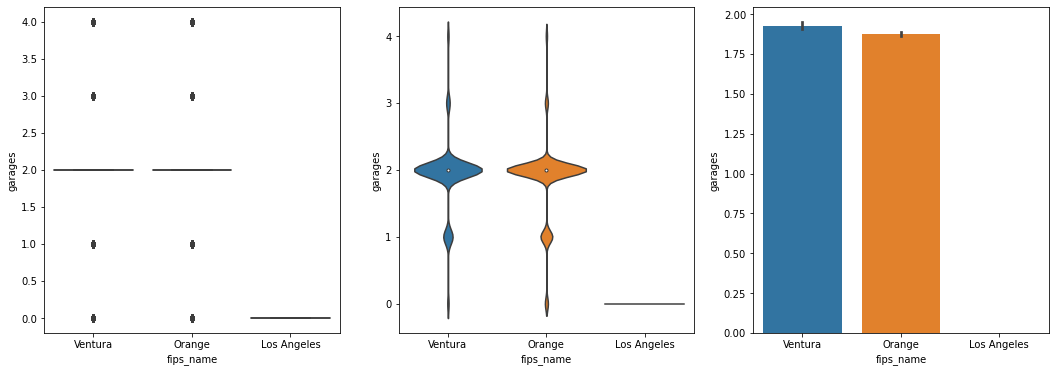

In [18]:
explore.plot_categorical_and_continuous_vars(train)

Plot all variables against target

<Figure size 648x648 with 0 Axes>

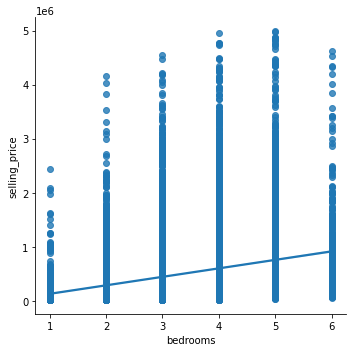

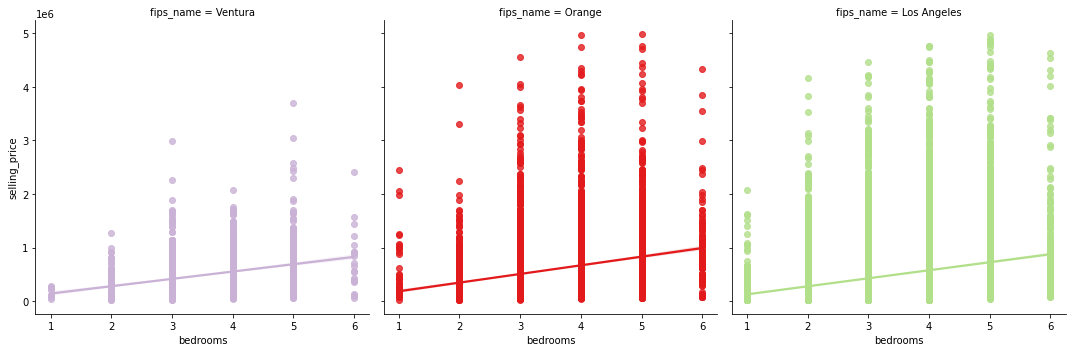

<Figure size 648x648 with 0 Axes>

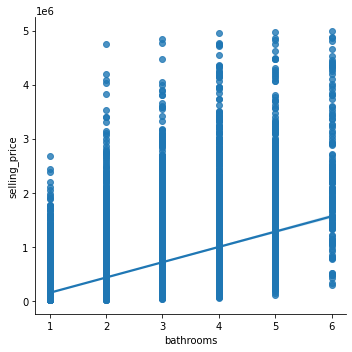

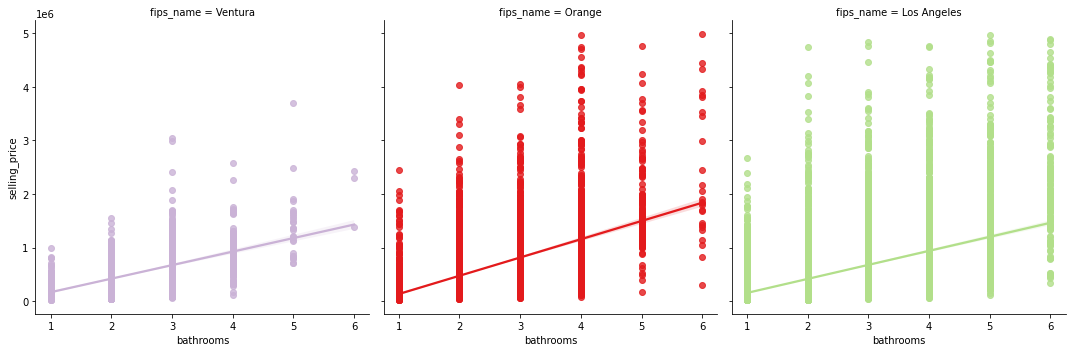

<Figure size 648x648 with 0 Axes>

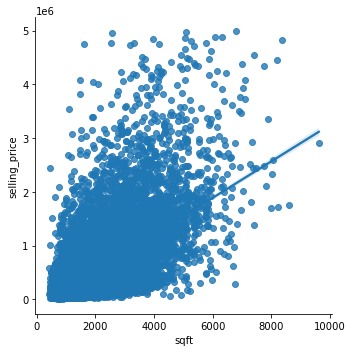

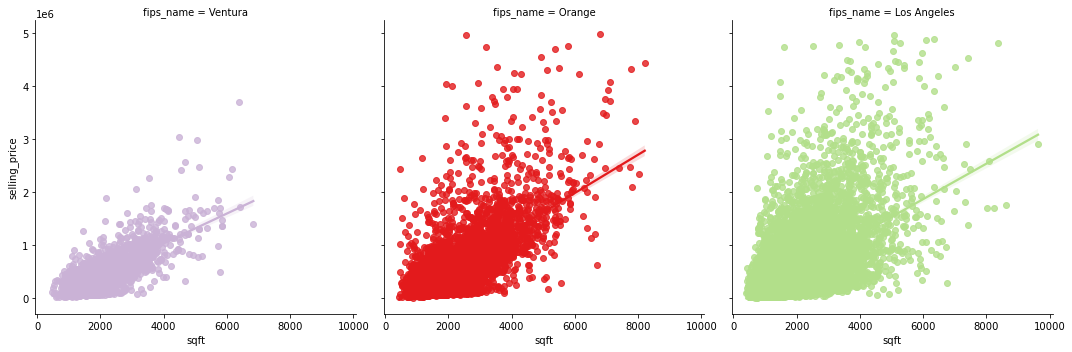

<Figure size 648x648 with 0 Axes>

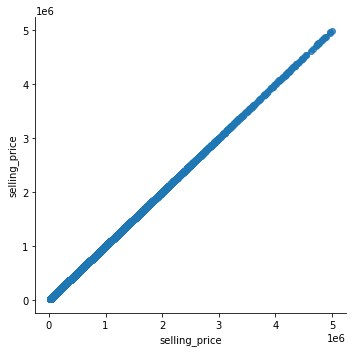

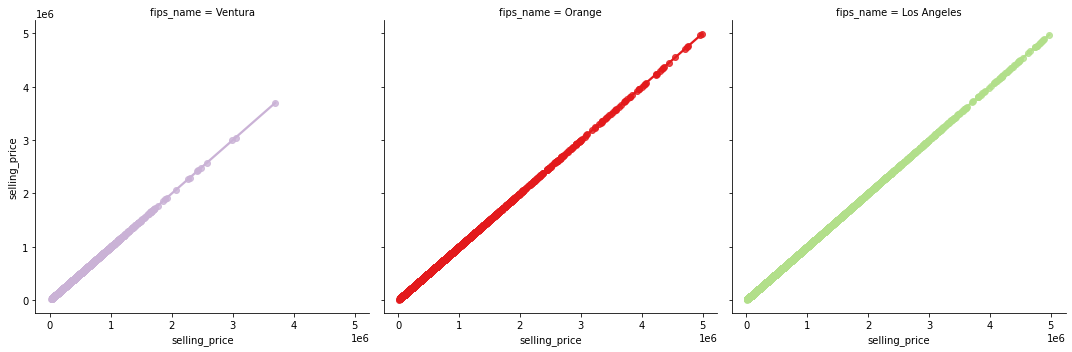

<Figure size 648x648 with 0 Axes>

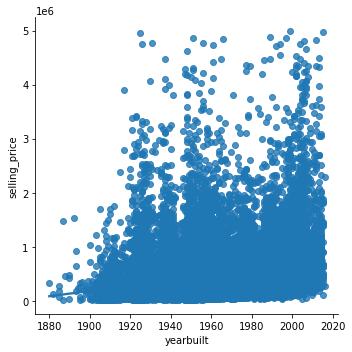

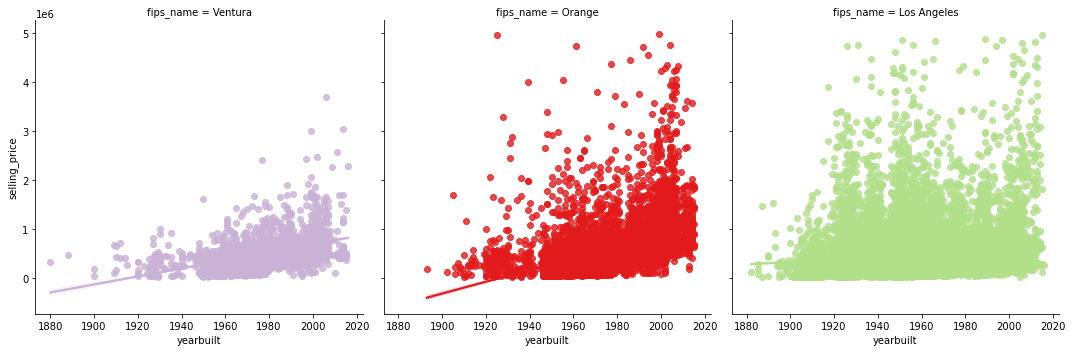

<Figure size 648x648 with 0 Axes>

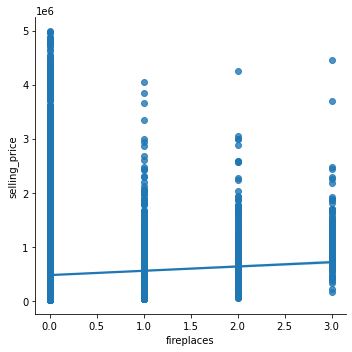

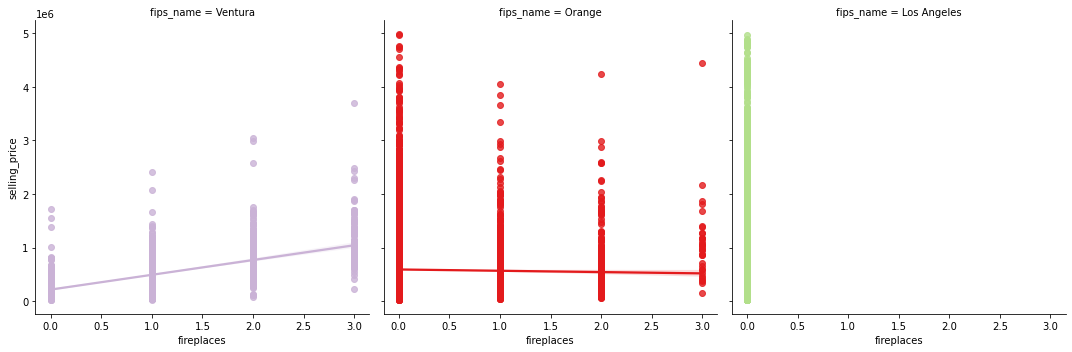

<Figure size 648x648 with 0 Axes>

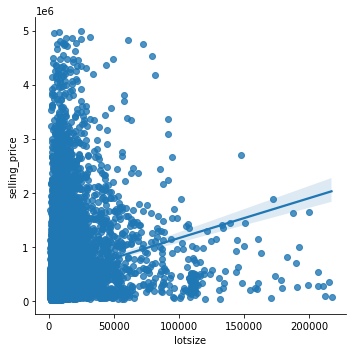

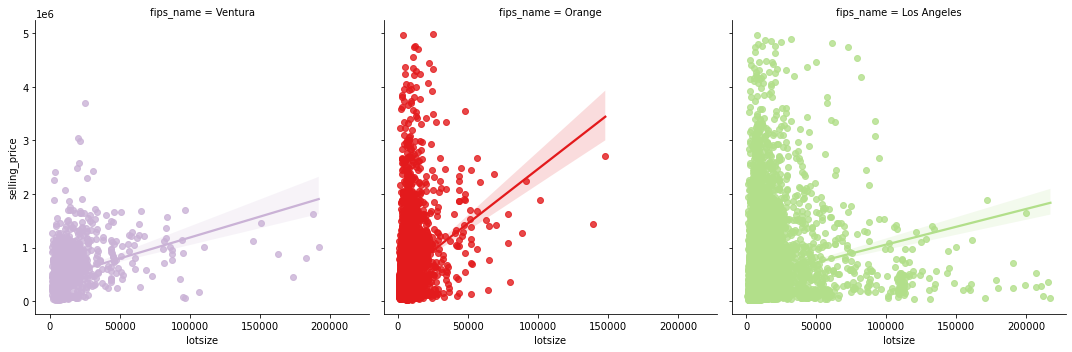

<Figure size 648x648 with 0 Axes>

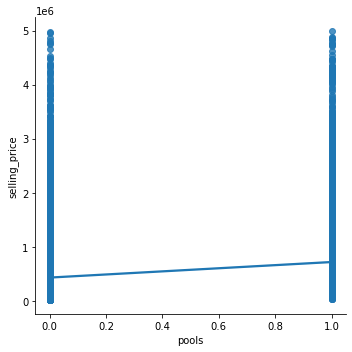

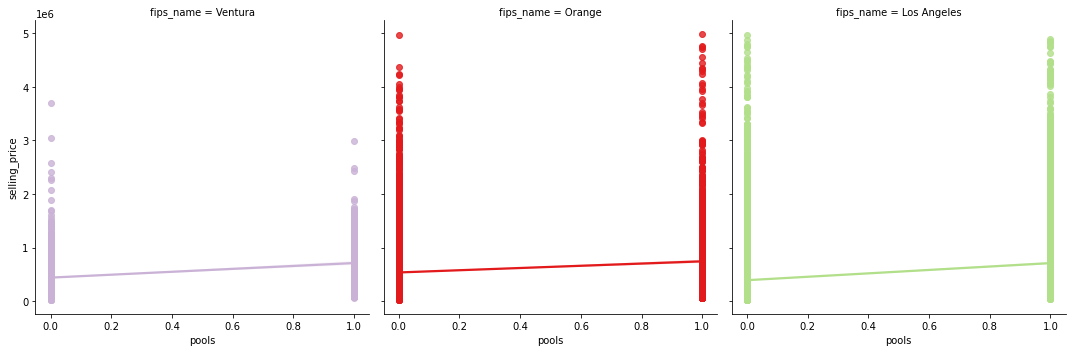

<Figure size 648x648 with 0 Axes>

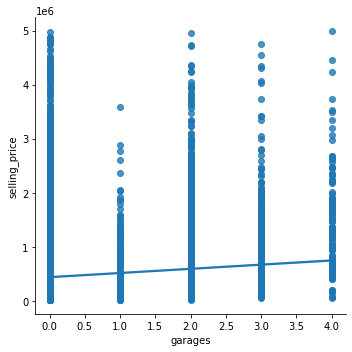

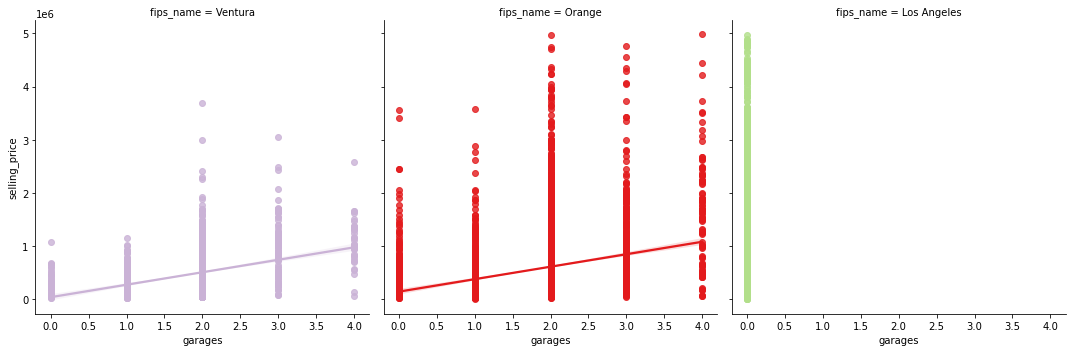

In [19]:
num_cols = [col for col in train.columns if train[col].dtype != 'object']

for i in num_cols:
    plt.figure(figsize = (9,9))
    sns.color_palette('Greys')
    sns.lmplot(data = train, x=i, y='selling_price')
    sns.lmplot(data = train, x=i, y='selling_price', col = 'fips_name', hue='fips_name', palette='Paired_r')
    plt.show()

##### Looking at the charts, I see that there are no garages or fireplaces for any of the Los Angeles homes.  Since LA is the majority of the dataset, I will remove these features as unimportant.  Thinking about statistical tests:
1. Homes with pools have a higher selling_price than homes without. (t-test)
2. Orange county has the highest selling_price, followed by Ventura and then LA (mutliple t-tests)
3. More bathrooms correlated with higher selling_price (pearsons)
4. More bedrooms correlated with higher selling_price (pearsons)
5. Higher square footage correlated with higher selling_price (pearsons)
6. Larger lot size correlated with higher selling_prices (pearsons)

## Hypotheses testing

In [20]:
import scipy.stats as stats
alpha = .05

#### 1. Do homes with pools have a higher selling_price than homes without? (one-sided, independent t-test)

$H_{0}$ = Homes with pools have the same or lower selling_prices than homes without.

$H_{1}$ = Homes with pools have a higher selling_price than homes without.

Assumptions: (X)Independent | (X) Normal (or 30+ obs) | (?) Equal variances?

In [21]:
print(train[train['pools']==1].selling_price.var())
print(train[train['pools']==0].selling_price.var())

438338775825.0908
178548337815.29315


*Must set equal_var to False*

In [22]:
t, p = stats.ttest_ind(train[train['pools']==1].selling_price, train[train['pools']==0].selling_price, equal_var=False)
t, p / 2

(31.734759565601866, 2.7910741368416667e-207)

In [23]:
print("Is t < 0? ", t < 0)
print("is p/2 < alpha? ", p / 2 < alpha)

Is t < 0?  False
is p/2 < alpha?  True


We REJECT the null hypothesis that homes with pools have the same or lower selling_prices than homes without. 

#### 2. Does Orange county have the highest mean selling_prices followed by Ventura and then LA? (mutliple one sided, independent t-tests)
$H_{0}$ = X-fip has the same or lower selling_prices than Y-fip without.

$H_{1}$ = X-fip has a higher selling_price than Y-fip without.

where X1 is Orange, Y1 is Ventura, X2 is Ventura and Y2 is Los Angeles

Assumptions: (X)Independent | (X) Normal (or 30+ obs) | (?) Equal variances?

In [24]:
print(train[train['fips_name']=='Orange'].selling_price.var())
print(train[train['fips_name']=='Ventura'].selling_price.var())
print(train[train['fips_name']=='Los Angeles'].selling_price.var())

265439932270.81583
111720031043.24547
249422757791.25305


*While Orange and LA have equal variances, I'll go ahead and set to False when comparing to Ventura*

1. Orange vs Ventura

In [25]:
t, p = stats.ttest_ind(train[train['fips_name']=='Orange'].selling_price, train[train['fips_name']=='Ventura'].selling_price, equal_var=False)
t, p / 2

(10.171327391192742, 2.0651154178838286e-24)

We REJECT the null hypothesis that Orange has the same or lower selling_prices than Ventura.

In [26]:
t, p = stats.ttest_ind(train[train['fips_name']=='Ventura'].selling_price, train[train['fips_name']=='Los Angeles'].selling_price, equal_var=False)
t, p / 2

(4.979410616295791, 3.326257293813386e-07)

We REJECT the null hypothesis that Ventura has the same or lower selling_prices than Los Angeles.

#### 3. More bathrooms correlated with selling_price (pearsons)
$H_{0}$ = Bathrooms are not correlated with selling_price.

$H_{1}$ = Bathrooms are correlated with selling_price.

In [27]:
corr, p = stats.pearsonr(train.bathrooms, train.selling_price)
corr, p

(0.5232052505633468, 0.0)

We REJECT the null hypothesis that bathrooms are not correlated with selling_price.

#### 4. More bedrooms correlated with higher selling_price (pearsons)
$H_{0}$ = Bedrooms are not correlated with selling_price.

$H_{1}$ = Bedrooms are correlated with selling_price.

In [28]:
corr, p = stats.pearsonr(train.bedrooms, train.selling_price)
corr, p

(0.28166932356825847, 0.0)

We REJECT the null hypothesis that bathrooms are not correlated with selling_price.

#### 5. Higher square footage correlated with higher selling_price (pearsons)
$H_{0}$ = Square footage of home is not correlated with selling_price.

$H_{1}$ = Square footage of home is correlated with selling_price.

In [29]:
corr, p = stats.pearsonr(train.sqft, train.selling_price)
corr, p

(0.609918103839217, 0.0)

We REJECT the null hypothesis that square footage of him is not correlated with selling_price.

#### 6. Larger lot size correlated with higher selling_prices (pearsons)
$H_{0}$ = Lot size is not correlated with selling_price.

$H_{1}$ = Lot size is correlated with selling_price.

In [30]:
corr, p = stats.pearsonr(train.lotsize, train.selling_price)
corr, p

(0.16378616362373216, 1.0376530376005665e-171)

We REJECT the null hypothesis that lot size is not correlated with selling_price.

## EDA Outcomes:

1. Orange county is associated with the highest selling_price, then Ventura then LA.
2. Bathrooms highly correlated with square feet, and sqft is better corelated with selling_price, so dropping bathrooms.
3. Bedrooms are relevant so keep them
4. Pools are so keep them
5. Lot size and pool correlated with higher selling_prices, albeit not as strongly.
6. Dropping garages and fireplaces.
7. Quality metric both wrong (higher seems better), was only for LA, and didn't improve an LA-only parallel model, but seems very interesting.

# V. FEATURE ENGINEERING

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28698 entries, 24401 to 18737
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   bedrooms       28698 non-null  int64 
 1   bathrooms      28698 non-null  int64 
 2   sqft           28698 non-null  int64 
 3   selling_price  28698 non-null  int64 
 4   yearbuilt      28698 non-null  int64 
 5   fireplaces     28698 non-null  int64 
 6   lotsize        28698 non-null  int64 
 7   pools          28698 non-null  int64 
 8   garages        28698 non-null  int64 
 9   fips_name      28698 non-null  object
dtypes: int64(9), object(1)
memory usage: 3.4+ MB


In [32]:
columns_to_remove = ['bathrooms','fireplaces','garages']
train = train.drop(columns = columns_to_remove)
train

,bedrooms,sqft,selling_price,yearbuilt,lotsize,pools,fips_name
24401,3,1163,505000,2000,3757,0,Ventura
11376,4,2633,420576,1994,8000,0,Orange
41985,3,1401,320607,1937,5963,1,Los Angeles
1184,5,3762,1057082,1980,20366,1,Ventura
8066,5,3170,777109,1979,10000,1,Orange
...,...,...,...,...,...,...,...
38232,3,939,350260,1962,4997,0,Los Angeles
6148,3,1825,334507,1964,7800,0,Orange
45700,3,2084,268418,1969,7200,1,Orange
38230,5,5540,2979716,1928,37133,1,Los Angeles


In [33]:
validate = validate.drop(columns = columns_to_remove)
test = test.drop(columns = columns_to_remove)

#### Scaling the datasets:

In [34]:
train_scaled, validate_scaled, test_scaled = scale_zillow(train, validate, test)
train_scaled.sample(10)

,bedrooms,sqft,yearbuilt,lotsize,pools,fips_name,selling_price,fips_name_Los Angeles,fips_name_Orange,fips_name_Ventura
50128,0.2,0.020494,0.529412,0.237252,0.0,Los Angeles,130768,1,0,0
18584,0.4,0.207764,0.926471,0.022730,0.0,Ventura,384200,0,0,1
23411,0.6,0.493277,0.911765,0.067808,1.0,Orange,2616983,0,1,0
15307,0.6,0.267946,0.926471,0.030120,0.0,Los Angeles,305000,1,0,0
43026,0.6,0.371828,0.867647,0.025341,0.0,Orange,1215717,0,1,0
5216,0.4,0.121991,0.750000,0.031642,0.0,Los Angeles,198000,1,0,0
4505,1.0,0.312297,0.426471,0.214010,1.0,Los Angeles,220526,1,0,0
51014,0.8,0.377575,0.639706,0.077208,1.0,Los Angeles,216853,1,0,0
23205,0.8,0.117653,0.338235,0.023408,0.0,Los Angeles,432902,1,0,0
26924,0.4,0.077640,0.492647,0.028754,0.0,Los Angeles,82034,1,0,0


#### Seperate target and features:

In [35]:
X_train = train_scaled.drop(columns=['fips_name','selling_price'])
y_train = train_scaled.selling_price

X_validate = validate_scaled.drop(columns=['fips_name','selling_price'])
y_validate = validate_scaled.selling_price

X_test = test_scaled.drop(columns=['fips_name','selling_price'])
y_test = test_scaled.selling_price

### Feature Selection Algorithms:

In [36]:
from sklearn.feature_selection import SelectKBest, f_regression

for i in range(1,9):
    # parameters: f_regression stats test, give me 8 features
    f_selector = SelectKBest(f_regression, k=i)

    # find the top 8 X's correlated with y
    f_selector.fit(X_train, y_train)

    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector.get_support()

    # get list of top K features. 
    f_feature = X_train.iloc[:,feature_mask].columns.tolist()
    print(f_feature)

['sqft']
['bedrooms', 'sqft']
['bedrooms', 'sqft', 'pools']
['bedrooms', 'sqft', 'yearbuilt', 'pools']
['bedrooms', 'sqft', 'yearbuilt', 'lotsize', 'pools']
['bedrooms', 'sqft', 'yearbuilt', 'lotsize', 'pools', 'fips_name_Orange']
['bedrooms', 'sqft', 'yearbuilt', 'lotsize', 'pools', 'fips_name_Los Angeles', 'fips_name_Orange']
['bedrooms', 'sqft', 'yearbuilt', 'lotsize', 'pools', 'fips_name_Los Angeles', 'fips_name_Orange', 'fips_name_Ventura']


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV

for i in range(1,9):
# initialize the ML algorithm
    lm = LinearRegression()

    # create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
    rfe = RFE(lm, n_features_to_select=i)

    # fit the data using RFE
    rfe.fit(X_train,y_train)  

    # get the mask of the columns selected
    feature_mask = rfe.support_

    # get list of the column names. 
    rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
    print(rfe_feature)

rfecv = RFECV(lm, min_features_to_select = 1)
rfecv.fit(X_train, y_train)
feature_mask = rfecv.support_
rfecv_feature = X_train.iloc[:,feature_mask].columns.tolist()
print(rfecv_feature)

['sqft']
['sqft', 'fips_name_Ventura']
['sqft', 'fips_name_Orange', 'fips_name_Ventura']
['sqft', 'fips_name_Los Angeles', 'fips_name_Orange', 'fips_name_Ventura']
['bedrooms', 'sqft', 'fips_name_Los Angeles', 'fips_name_Orange', 'fips_name_Ventura']
['bedrooms', 'sqft', 'lotsize', 'fips_name_Los Angeles', 'fips_name_Orange', 'fips_name_Ventura']
['bedrooms', 'sqft', 'yearbuilt', 'lotsize', 'fips_name_Los Angeles', 'fips_name_Orange', 'fips_name_Ventura']
['bedrooms', 'sqft', 'yearbuilt', 'lotsize', 'pools', 'fips_name_Los Angeles', 'fips_name_Orange', 'fips_name_Ventura']
['bedrooms', 'sqft', 'yearbuilt', 'lotsize', 'pools', 'fips_name_Los Angeles', 'fips_name_Orange', 'fips_name_Ventura']


##### I performed both a SelecKBest and RFE.  RFE ran without issue and is considered the superior one, so went with it.
##### Then used an RFE Cross Validation funtion to determine optial number of features, and it looks like we should model using all of the features.

# VI. MODELING

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [39]:
model_comparator = []

#### BASELINE:

In [40]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict target_pred_mean
selling_price_pred_mean = y_train['selling_price'].mean()
y_train['selling_price_pred_mean'] = selling_price_pred_mean
y_validate['selling_price_pred_mean'] = selling_price_pred_mean

# 2. compute target_pred_median
selling_price_pred_median = y_train['selling_price'].median()
y_train['selling_price_pred_median'] = selling_price_pred_median
y_validate['selling_price_pred_median'] = selling_price_pred_median

# 3. RMSE of target_pred_mean
rmse_train_mean = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_mean)**(1/2)
rmse_validate_mean = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 5))

# 4. RMSE of target_pred_median
rmse_train_median = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_median)**(1/2)
rmse_validate_median = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_median, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_median, 5))

results = {'Model' : 'Baseline Median','RMSE Train':rmse_train_median,'RMSE Validate':rmse_validate_median}
model_comparator.append(results)
results = {'Model' : 'Baseline Mean','RMSE Train':rmse_train_mean,'RMSE Validate':rmse_validate_mean}
model_comparator.append(results)

RMSE using Mean
Train/In-Sample:  495485.97678 
Validate/Out-of-Sample:  465856.70737
RMSE using Median
Train/In-Sample:  510083.1964 
Validate/Out-of-Sample:  479220.83355


#### OLS:

In [41]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.selling_price)

# predict train
y_train['selling_price_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train_ols = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lm)**(1/2)

# predict validate
y_validate['selling_price_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate_ols = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols, 
      "\nValidation/Out-of-Sample: ", rmse_validate_ols)

results = {'Model' : 'OLS','RMSE Train':rmse_train_ols,'RMSE Validate':rmse_validate_ols}
model_comparator.append(results)

RMSE for OLS using LinearRegression
Training/In-Sample:  384906.39842239546 
Validation/Out-of-Sample:  369566.43744094815


#### LASSOLARS:

In [42]:
# create the model object
lars = LassoLars(alpha=2.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.selling_price)

# predict train
y_train['selling_price_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train_lassolars = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lars)**(1/2)

# predict validate
y_validate['selling_price_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate_lassolars = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lassolars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lassolars)

results = {'Model' : 'LassoLars','RMSE Train':rmse_train_lassolars,'RMSE Validate':rmse_validate_lassolars}
model_comparator.append(results)

RMSE for Lasso + Lars
Training/In-Sample:  384900.1347973966 
Validation/Out-of-Sample:  369482.21796410286


#### TWEEDIE

In [43]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.selling_price)

# predict train
y_train['selling_price_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_glm)**(1/2)

# predict validate
y_validate['selling_price_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train_glm, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)

results = {'Model' : 'GLM','RMSE Train':rmse_train_glm,'RMSE Validate':rmse_validate_glm}
model_comparator.append(results)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  416065.37577210896 
Validation/Out-of-Sample:  392293.512460416


#### POLYNOMIAL - DEGREE 2

In [44]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [45]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.selling_price)

# predict train
y_train['selling_price_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_p2 = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lm2)**(1/2)

# predict validate
y_validate['selling_price_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate_p2 = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_p2, 
      "\nValidation/Out-of-Sample: ", rmse_validate_p2)

results = {'Model' : 'Polynomial, Deg. 2','RMSE Train':rmse_train_p2,'RMSE Validate':rmse_validate_p2}
model_comparator.append(results)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  377835.3645823452 
Validation/Out-of-Sample:  363473.9072958712


In [46]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [47]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.selling_price)

# predict train
y_train['selling_price_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train_p3 = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lm3)**(1/2)

# predict validate
y_validate['selling_price_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate_p3 = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train_p3, 
      "\nValidation/Out-of-Sample: ", rmse_validate_p3)

results = {'Model' : 'Polynomial, Deg. 3','RMSE Train':rmse_train_p3,'RMSE Validate':rmse_validate_p3}
model_comparator.append(results)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  370900.6881775274 
Validation/Out-of-Sample:  360923.02494560473


In [48]:
df_results = pd.DataFrame(model_comparator).round(2).set_index('Model')
df_results_SP = df_results.copy()
df_results['Overfit %'] = (100*(df_results['RMSE Validate'] - df_results['RMSE Train'])/df_results['RMSE Train']).round(2)  
df_results.T

Model,Baseline Median,Baseline Mean,OLS,LassoLars,GLM,"Polynomial, Deg. 2","Polynomial, Deg. 3"
RMSE Train,510083.20,495485.98,384906.40,384900.13,416065.38,377835.36,370900.69
RMSE Validate,479220.83,465856.71,369566.44,369482.22,392293.51,363473.91,360923.02
Overfit %,-6.05,-5.98,-3.99,-4.01,-5.71,-3.80,-2.69


#### Polynomial Regression of Degree 3 is the best

# VII. TEST

In [49]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['selling_price_pred_lm'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.selling_price, y_test.selling_price_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  381791.6142890145


# VIII.  CONCLUSIONS AND RECOMMENDATIONS

# IX. BY FIPS ANALYIS

### Decided to see if mode can be improved when built county by county

In [50]:
df_fips = df.drop(columns=['bathrooms','fireplaces','garages'])
df_fips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51248 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   bedrooms       51248 non-null  int64 
 1   sqft           51248 non-null  int64 
 2   selling_price  51248 non-null  int64 
 3   yearbuilt      51248 non-null  int64 
 4   lotsize        51248 non-null  int64 
 5   pools          51248 non-null  int64 
 6   fips_name      51248 non-null  object
dtypes: int64(6), object(1)
memory usage: 3.1+ MB


In [51]:
df_o = df_fips[df_fips['fips_name'] == 'Orange']
df_v = df_fips[df_fips['fips_name'] == 'Ventura']
df_la = df_fips[df_fips['fips_name'] == 'Los Angeles']

In [52]:
df_o = df_o.drop(columns = 'fips_name')
df_v = df_v.drop(columns = 'fips_name')
df_la = df_la.drop(columns = 'fips_name')
df_o.head()

,bedrooms,sqft,selling_price,yearbuilt,lotsize,pools
0,4,3100,1023282,1998,4506,0
2,3,1243,564778,1962,8432,1
8,3,1340,319668,1980,1199,0
10,4,1677,528847,1981,5304,0
12,3,2074,597213,1978,5600,0


In [53]:
import sklearn.preprocessing
fips_list = [df_o,df_v,df_la]

counter = 1

for i in fips_list:
    model_comparator_fips = []
    # Split
    train, validate, test = splitter(i)
    # Scale
    # Create the object
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train.drop(columns='selling_price'))

    # Fit the data
    train_scaled = pd.DataFrame(scaler.transform(train.drop(columns=['selling_price'])),columns=train.drop(columns=['selling_price']).columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate.drop(columns=['selling_price'])),columns=validate.drop(columns=['selling_price']).columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test.drop(columns=['selling_price'])),columns=test.drop(columns=['selling_price']).columns.values).set_index([test.index.values])

    # Add back in the target, selling_price
    train_scaled['selling_price'] = train['selling_price']
    validate_scaled['selling_price'] = validate['selling_price']
    test_scaled['selling_price'] = test['selling_price']
    # Drop fips data and seperate into target and features
    X_train = train_scaled.drop(columns='selling_price')
    y_train = train_scaled.selling_price

    X_validate = validate_scaled.drop(columns='selling_price')
    y_validate = validate_scaled.selling_price

    X_test = test_scaled.drop(columns='selling_price')
    y_test = test_scaled.selling_price
    # Run Tests!
    # We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)

    # 1. Predict target_pred_mean
    selling_price_pred_mean = y_train['selling_price'].mean()
    y_train['selling_price_pred_mean'] = selling_price_pred_mean
    y_validate['selling_price_pred_mean'] = selling_price_pred_mean

    # 2. compute target_pred_median
    selling_price_pred_median = y_train['selling_price'].median()
    y_train['selling_price_pred_median'] = selling_price_pred_median
    y_validate['selling_price_pred_median'] = selling_price_pred_median

    # 3. RMSE of target_pred_mean
    rmse_train_mean = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_mean)**(1/2)
    rmse_validate_mean = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_mean)**(1/2)


    # 4. RMSE of target_pred_median
    rmse_train_median = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_median)**(1/2)
    rmse_validate_median = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_median)**(1/2)

    results = {'Model' : 'Baseline Median','RMSE Train':rmse_train_median,'RMSE Validate':rmse_validate_median}
    model_comparator_fips.append(results)
    results = {'Model' : 'Baseline Mean','RMSE Train':rmse_train_mean,'RMSE Validate':rmse_validate_mean}
    model_comparator_fips.append(results)
    # create the model object
    lm = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm.fit(X_train, y_train.selling_price)

    # predict train
    y_train['selling_price_pred_lm'] = lm.predict(X_train)

    # evaluate: rmse
    rmse_train_ols = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lm)**(1/2)

    # predict validate
    y_validate['selling_price_pred_lm'] = lm.predict(X_validate)

    # evaluate: rmse
    rmse_validate_ols = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lm)**(1/2)

    results = {'Model' : 'OLS','RMSE Train':rmse_train_ols,'RMSE Validate':rmse_validate_ols}
    model_comparator_fips.append(results)
    # create the model object
    lars = LassoLars(alpha=2.0)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lars.fit(X_train, y_train.selling_price)

    # predict train
    y_train['selling_price_pred_lars'] = lars.predict(X_train)

    # evaluate: rmse
    rmse_train_lassolars = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lars)**(1/2)

    # predict validate
    y_validate['selling_price_pred_lars'] = lars.predict(X_validate)

    # evaluate: rmse
    rmse_validate_lassolars = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lars)**(1/2)

    results = {'Model' : 'LassoLars','RMSE Train':rmse_train_lassolars,'RMSE Validate':rmse_validate_lassolars}
    model_comparator_fips.append(results)
    # create the model object
    glm = TweedieRegressor(power=1, alpha=0)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    glm.fit(X_train, y_train.selling_price)

    # predict train
    y_train['selling_price_pred_glm'] = glm.predict(X_train)

    # evaluate: rmse
    rmse_train_glm = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_glm)**(1/2)

    # predict validate
    y_validate['selling_price_pred_glm'] = glm.predict(X_validate)

    # evaluate: rmse
    rmse_validate_glm = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_glm)**(1/2)

    results = {'Model' : 'GLM','RMSE Train':rmse_train_glm,'RMSE Validate':rmse_validate_glm}
    model_comparator_fips.append(results)
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=2)

    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train)

    # transform X_validate_scaled & X_test_scaled
    X_validate_degree2 = pf.transform(X_validate)
    X_test_degree2 = pf.transform(X_test)
    # create the model object
    lm2 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm2.fit(X_train_degree2, y_train.selling_price)

    # predict train
    y_train['selling_price_pred_lm2'] = lm2.predict(X_train_degree2)

    # evaluate: rmse
    rmse_train_p2 = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lm2)**(1/2)

    # predict validate
    y_validate['selling_price_pred_lm2'] = lm2.predict(X_validate_degree2)

    # evaluate: rmse
    rmse_validate_p2 = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lm2)**(1/2)

    results = {'Model' : 'Polynomial, Deg. 2','RMSE Train':rmse_train_p2,'RMSE Validate':rmse_validate_p2}
    model_comparator_fips.append(results)
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=3)

    # fit and transform X_train_scaled
    X_train_degree3 = pf.fit_transform(X_train)

    # transform X_validate_scaled & X_test_scaled
    X_validate_degree3 = pf.transform(X_validate)
    X_test_degree3 = pf.transform(X_test)
    # create the model object
    lm3 = LinearRegression(normalize=True)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series! 
    lm3.fit(X_train_degree3, y_train.selling_price)

    # predict train
    y_train['selling_price_pred_lm3'] = lm3.predict(X_train_degree3)

    # evaluate: rmse
    rmse_train_p3 = mean_squared_error(y_train.selling_price, y_train.selling_price_pred_lm3)**(1/2)

    # predict validate
    y_validate['selling_price_pred_lm3'] = lm3.predict(X_validate_degree3)

    # evaluate: rmse
    rmse_validate_p3 = mean_squared_error(y_validate.selling_price, y_validate.selling_price_pred_lm3)**(1/2)

    results = {'Model' : 'Polynomial, Deg. 3','RMSE Train':rmse_train_p3,'RMSE Validate':rmse_validate_p3}
    model_comparator_fips.append(results)
    
    if counter == 1:
        print('Orange County Results')
    elif counter == 2:
        print('Ventura County Results')
    else:
        print('Los Angeles Country Results')
    df_results2 = pd.DataFrame(model_comparator_fips).round(2).set_index('Model') 
    df_results2['Overfit %'] = (100*(df_results2['RMSE Validate'] - df_results2['RMSE Train'])/df_results2['RMSE Train']).round(2)  
    print(df_results2)
    print('\n-----\n')
    counter+=1
    

Train = 7769 rows (56.0%) | Validate = 3331 rows (24.0%) | Test = 2776 rows (20.0%)
You did not stratify.  If looking to stratify, ensure to add argument: "target = variable to stratify on".
Orange County Results
                    RMSE Train  RMSE Validate  Overfit %
Model                                                   
Baseline Median      505733.50      512455.26       1.33
Baseline Mean        494507.22      500967.04       1.31
OLS                  359168.54      378713.13       5.44
LassoLars            359168.86      378723.99       5.44
GLM                  358194.29      368650.85       2.92
Polynomial, Deg. 2   345273.38      360692.31       4.47
Polynomial, Deg. 3   341200.53      360817.09       5.75

-----

Train = 2388 rows (56.0%) | Validate = 1024 rows (24.0%) | Test = 854 rows (20.0%)
You did not stratify.  If looking to stratify, ensure to add argument: "target = variable to stratify on".
Ventura County Results
                    RMSE Train  RMSE Validate  Overfi

Overall - P3 Best Model

In [54]:
(465856-360923)/465856

0.22524771603242202

Orange - GLM Best Model

In [55]:
(500967-368651)/500967

0.26412118961927633

Ventura - P2 Best Model

In [56]:
(328114-206407)/328114

0.3709290063819282

Los Angeles - P2 Best Model

In [57]:
(479080-394933)/479080

0.17564289888953827